# Binary Classification Machine Learning. Case Study Loan Prediction

## 1 Problem Definition

The aim of this exercise is to use **Machine Learning** techniques to predict loan eligibility based on customer details. These details are numerical and categorical data that include information about gender, marital status, education, dependents, income, loan amount, credit history, and others. The label of each record is the letter `Y` if the loan is approved and `N` is the loan is rejected.

The training dataset contains the following information:

<table><tbody><tr><td width="155"><p><strong>Variable</strong></p></td><td width="465"><p>Description</p></td></tr><tr><td width="155"><p><strong>Loan_ID</strong></p></td><td width="465"><p>Unique Loan ID</p></td></tr><tr><td width="155"><p><strong>Gender</strong></p></td><td width="465"><p>Male/ Female</p></td></tr><tr><td width="155"><p><strong>Married</strong></p></td><td width="465"><p>Applicant married (Y/N)</p></td></tr><tr><td width="155"><p><strong>Dependents</strong></p></td><td width="465"><p>Number of dependents</p></td></tr><tr><td width="155"><p><strong>Education</strong></p></td><td width="465"><p>Applicant Education (Graduate/ Under Graduate)</p></td></tr><tr><td width="155"><p><strong>Self_Employed</strong></p></td><td width="465"><p>Self employed (Y/N)</p></td></tr><tr><td width="155"><p><strong>ApplicantIncome</strong></p></td><td width="465"><p>Applicant income</p></td></tr><tr><td width="155"><p><strong>CoapplicantIncome</strong></p></td><td width="465"><p>Coapplicant income</p></td></tr><tr><td width="155"><p><strong>LoanAmount</strong></p></td><td width="465"><p>Loan amount in thousands</p></td></tr><tr><td width="155"><p><strong>Loan_Amount_Term</strong></p></td><td width="465"><p>Term of loan in months</p></td></tr><tr><td width="155"><p><strong>Credit_History</strong></p></td><td width="465"><p>credit history meets guidelines</p></td></tr><tr><td width="155"><p><strong>Property_Area</strong></p></td><td width="465"><p>Urban/ Semi Urban/ Rural</p></td></tr><tr><td width="155"><p><strong>Loan_Status</strong></p></td><td width="465"><p>Loan approved (Y/N)</p></td></tr></tbody></table><p> 
    
The test dataset contains the same columns as the training dataset except the last one (Loan approved).

To solve this problem we will implement a Machine Learning solution based on data transformation and algorithm tuning to improve model performance. This solution is inspired in the recipes contained in the book [**Machine Learning Mastery With Python**](https://machinelearningmastery.com/machine-learning-with-python/) by Jason Brownlee.

## 2 Load the Dataset

First, we will load the required libraries to accomplish our goals.

In [1]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import set_option
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

### 2.1 Loading training dataset

In [2]:
# load dataset
df = pd.read_csv('train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


According to the output, some columns columns have categorical data and other columns have numerical data.

## 3. Imputation of missing values for categorical and numerical values

As we do not want to reduce the amount of data for our Machine Learning solution, we need to fill null values with the most frequent one for each category in our dataframe. But first we will sum missing values for each column.

In [3]:
# sum missing values 
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

We have seven columns with missing values. Next, we will impute both categorical and numerical values and change the date type of some columns.

In [4]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df = pd.DataFrame(imp.fit_transform(df),columns=df.columns,index=df.index)

In [5]:
df = df.astype({'ApplicantIncome': np.int64, 'CoapplicantIncome':float,
                'LoanAmount':float,'Loan_Amount_Term':float, 'Credit_History':float})

## 4. Transforming Categorical Data

In this section we will transform categorical data because Machine Learning algorithm cannot deal with this type of data. 

First, we will get unique values form categorical columns.

In [6]:
print(df.Gender.unique(),
df.Married.unique(),
df.Dependents.unique(),
df.Education.unique(),
df.Self_Employed.unique(),
df.Property_Area.unique(),
df.Loan_Status.unique())

['Male' 'Female'] ['No' 'Yes'] ['0' '1' '2' '3+'] ['Graduate' 'Not Graduate'] ['No' 'Yes'] ['Urban' 'Rural' 'Semiurban'] ['Y' 'N']


Next, we will create and apply a function to generate the encoding scheme for categorical data and write back labels to the DataFrame. Based on [Dipanjan (DJ) Sarkar post]((https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63)).

In [7]:
from sklearn.preprocessing import LabelEncoder
def encoding_schema(df, cat, label):
    
    '''Function to generate the encoding scheme for categorical data and 
        write back labels to the DataFrame
    '''
    gle = LabelEncoder()
    cat_labels = gle.fit_transform(df[cat])
    cat_mappings = {index: label for index, label in enumerate(gle.classes_)}
    
    df[label] = cat_labels.astype('int64')
    
    return ('Labels for {} are {}'.format(cat, cat_mappings))

In [8]:
# apply encoding_scheme to Gender 
encoding_schema(df, 'Gender', 'GenderLabel')

"Labels for Gender are {0: 'Female', 1: 'Male'}"

In [9]:
# apply encoding_scheme to Married 
encoding_schema(df, 'Married', 'MarriedLabel')

"Labels for Married are {0: 'No', 1: 'Yes'}"

In [10]:
# apply encoding_scheme to Dependents
encoding_schema(df, 'Dependents', 'DependentsLabel')

"Labels for Dependents are {0: '0', 1: '1', 2: '2', 3: '3+'}"

In [11]:
# apply encoding_scheme to Education
encoding_schema(df, 'Education', 'EducationLabel')

"Labels for Education are {0: 'Graduate', 1: 'Not Graduate'}"

In [12]:
# apply encoding_scheme to Self_Employed
encoding_schema(df, 'Self_Employed', 'Self_EmployedLabel')

"Labels for Self_Employed are {0: 'No', 1: 'Yes'}"

In [13]:
# apply encoding_scheme to Property_Area
encoding_schema(df, 'Property_Area', 'Property_AreaLabel')

"Labels for Property_Area are {0: 'Rural', 1: 'Semiurban', 2: 'Urban'}"

In [14]:
# apply encoding_scheme to Loan_Status
encoding_schema(df, 'Loan_Status', 'Loan_StatusLabel')

"Labels for Loan_Status are {0: 'N', 1: 'Y'}"

Finally, we will get rid of unuseful columns and rename back useful columns  

In [15]:
columns_to_keep  = ['Loan_ID', 'GenderLabel', 'MarriedLabel', 'DependentsLabel', 'EducationLabel',
       'Self_EmployedLabel', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_AreaLabel', 'Loan_StatusLabel']

df = df[columns_to_keep]

In [16]:
old_colnames  = ['GenderLabel', 'MarriedLabel', 'DependentsLabel', 'EducationLabel',
       'Self_EmployedLabel', 'Property_AreaLabel', 'Loan_StatusLabel']

new_colnames  = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status']

col_rename_dict = {i:j for i,j in zip(old_colnames,new_colnames)}
df = df.rename(columns=col_rename_dict)

## 5 Analyzing Data

After transforming our dataset, we can examine closely our data. 

### 5.1 Descriptive Statistics

Let's examine the number of rows and columns of our dataset

In [17]:
# shape
df.shape

(614, 13)

We have 614 samples to produce our solution and we can observe that our dataset contains 13 attributes including the target attribute `Loan_Status`.

Now, let's look at the data tye of each column



In [18]:
df.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
dtype: object

Nearly all column are numeric, some of them are real values (float) and others are integers (int).

Next, let's take a pick at the first 5 rows

In [19]:
set_option('display.width', 100)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,120.0,360.0,1.0,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


Through the output we can corroborate the columns are numeric and some of them have different scales, so it is possible we need to transform them latter on.

Next, we will summarize the distribution of each attribute.

In [20]:
set_option('precision', 3)
df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614.000,614.000,614.000,614.000,614.000,614.000,614.000,614.000,614.000,614.000,614.000,614.000
mean,0.818,0.653,0.744,0.218,0.134,5403.459,1621.246,145.466,342.410,0.855,1.037,0.687
std,0.386,0.476,1.010,0.413,0.340,6109.042,2926.248,84.181,64.429,0.352,0.787,0.464
min,0.000,0.000,0.000,0.000,0.000,150.000,0.000,9.000,12.000,0.000,0.000,0.000
25%,1.000,0.000,0.000,0.000,0.000,2877.500,0.000,100.250,360.000,1.000,0.000,0.000
50%,1.000,1.000,0.000,0.000,0.000,3812.500,1188.500,125.000,360.000,1.000,1.000,1.000
75%,1.000,1.000,1.000,0.000,0.000,5795.000,2297.250,164.750,360.000,1.000,2.000,1.000
max,1.000,1.000,3.000,1.000,1.000,81000.000,41667.000,700.000,480.000,1.000,2.000,1.000


We can observe our dataset has the same range, but they differ in mean values, so [Standardization](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf) could be beneficial.

Let's see the class distribution fro the `Loan_Status`

In [21]:
df.groupby(['Loan_Status']).size()

Loan_Status
0    192
1    422
dtype: int64

The class `Loans_Status` is imbalanced between YES(1) and NO(0)

### Unimodal Data Visualizations

It is useful to look at our data through different visualization techniques in order to get insights about its distribution.

Let's plot a histogram to observe the dataset class distribution

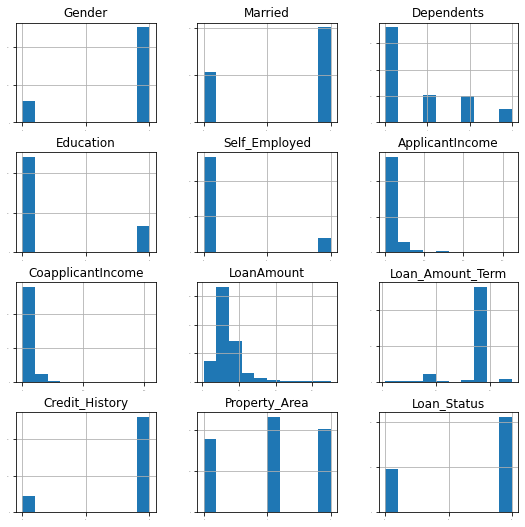

In [22]:
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(9,9))
plt.show();

We can see most of the class distributions are bimodal. For other attributes the distribution are skewed right or skewed left and Gaussian-like. 

We can observe easily this kind of distribution through [Density Plots](https://www.data-to-viz.com/graph/density.html#:~:text=A%20density%20plot%20is%20a,used%20in%20the%20same%20concept).

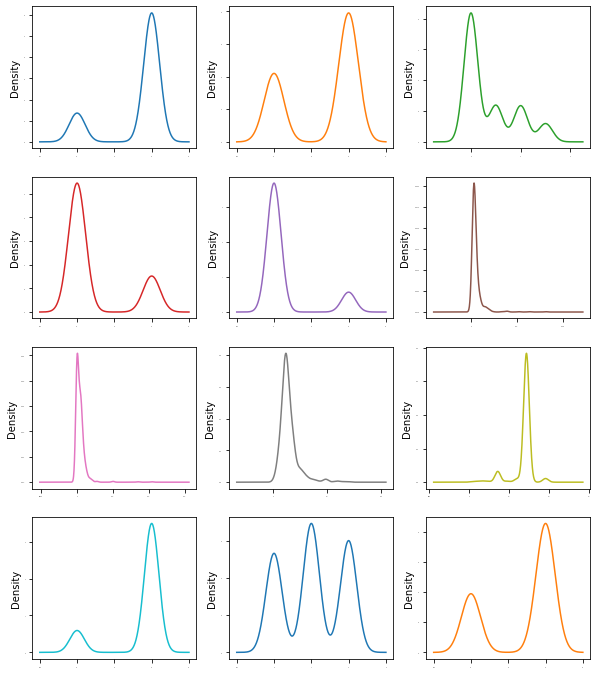

In [23]:
df.plot(kind='density', subplots=True, layout=(4,3), sharex=False, legend=False, fontsize=1, figsize=(10,12))
plt.show();

Let's look at the spread of attribute values using [whisker plots](https://en.wikipedia.org/wiki/Box_plot).  

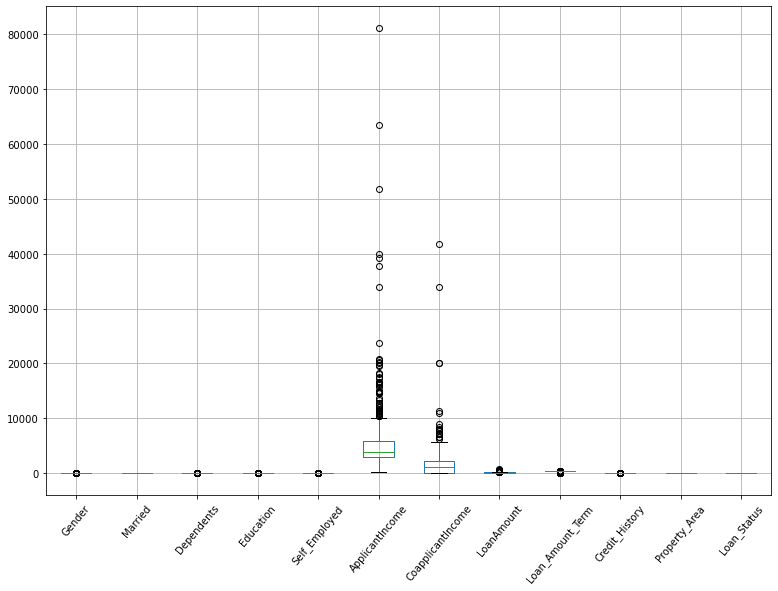

In [24]:
boxplot = df.boxplot(column=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area', 'Loan_Status'], figsize=(13, 9), rot=50)

Except for `ApplicantIncome`(Applicant income) and `CoapplicantIncome`(Coapplicant income), the attributes are not spread. When modeling it is possible to get some benefits if we standardize in order to line up mean values.

### Feature Selection

#### Univariate Selection
Based on  https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = df.iloc[:,1:12]  #independent column
y = df.iloc[:,12]    #target  column

# apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(5, 'Score'))  #print 5 best features

               Specs      Score
6  CoapplicantIncome  11342.042
5    ApplicantIncome     93.905
7         LoanAmount     30.214
9     Credit_History     26.006
8   Loan_Amount_Term      3.779


#### Correlation Matrix with Heatmap

In [29]:
import seaborn as sns

X = df.iloc[:,1:12]  #independent column
y = df.iloc[:,12]    #target column

# get correlations of each features in dataset
corrmat = df.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

# plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Validation Dataset

In [161]:
df['Loan_Status'] = df.Loan_Status.replace({0: 'N', 1: 'Y'})

In [162]:
# split-out validation dataset
array = df.values
X = array[:, 1:12].astype(float)
Y = array[:, -1]
validation_size = 0.30
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Evaluating Algorithms: Baseline

In [163]:
# test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

In [164]:
# spot-check Algoriths
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [165]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.808915 (0.032245)
KNN: 0.631728 (0.059356)
CART: 0.678239 (0.029938)
NB: 0.787929 (0.023846)
SVM: 0.699169 (0.080060)


Text(0.5, 0.98, 'Algorithm Comparison')

{'whiskers': [<matplotlib.lines.Line2D at 0x12cb595d30>,
 'caps': [<matplotlib.lines.Line2D at 0x12cb59e400>,
 'boxes': [<matplotlib.lines.Line2D at 0x12cb595978>,
 'medians': [<matplotlib.lines.Line2D at 0x12cb59ea90>,
 'fliers': [<matplotlib.lines.Line2D at 0x12cb59edd8>,
 'means': []}

[Text(0, 0, 'LR'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'SVM')]

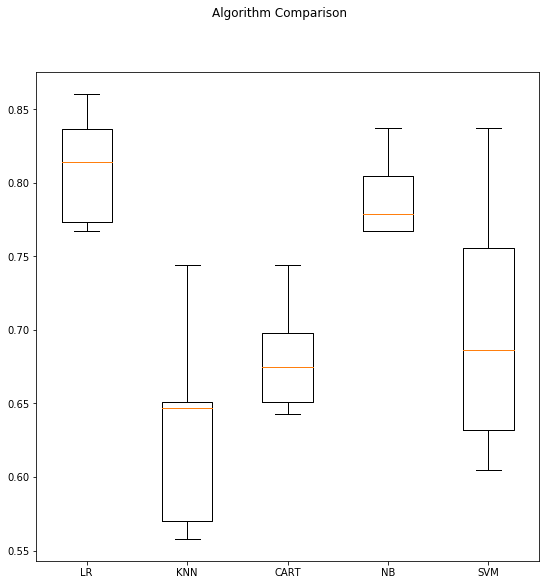

In [166]:
# compare algorithms 
fig = plt.figure(figsize=(9,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Evaluating Algorithms: Standardize Data

In [167]:
# standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.811240 (0.034929)
ScaledKNN: 0.780731 (0.034462)
ScaledCART: 0.678239 (0.054327)
ScaledNB: 0.794906 (0.024752)
ScaledSVM: 0.792525 (0.038202)


Text(0.5, 0.98, 'Scaled Algoritm Comparison')

{'whiskers': [<matplotlib.lines.Line2D at 0x12cadd0630>,
 'caps': [<matplotlib.lines.Line2D at 0x12cadd0cc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x12cadd0240>,
 'medians': [<matplotlib.lines.Line2D at 0x12caddc390>,
 'fliers': [<matplotlib.lines.Line2D at 0x12caddc6d8>,
 'means': []}

[Text(0, 0, 'ScaledLR'),
 Text(0, 0, 'ScaledKNN'),
 Text(0, 0, 'ScaledCART'),
 Text(0, 0, 'ScaledNB'),
 Text(0, 0, 'ScaledSVM')]

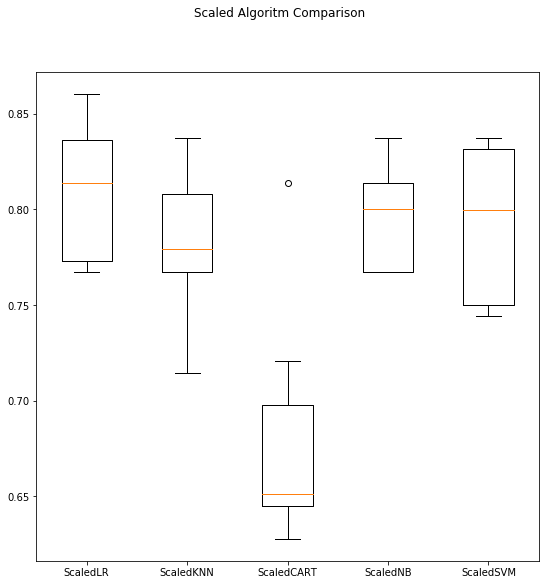

In [168]:
# compare algorithms
fig = plt.figure(figsize=(9,9))
fig.suptitle("Scaled Algoritm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Algorithm Tuning

### Tuning SVM

In [169]:
# tune scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.808858 using {'C': 0.1, 'kernel': 'linear'}
0.808858 (0.043682) with: {'C': 0.1, 'kernel': 'linear'}
0.773893 (0.048161) with: {'C': 0.1, 'kernel': 'poly'}
0.748252 (0.059955) with: {'C': 0.1, 'kernel': 'rbf'}
0.808858 (0.043682) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.808858 (0.043682) with: {'C': 0.3, 'kernel': 'linear'}
0.808858 (0.028704) with: {'C': 0.3, 'kernel': 'poly'}
0.804196 (0.045340) with: {'C': 0.3, 'kernel': 'rbf'}
0.808858 (0.041125) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.808858 (0.043682) with: {'C': 0.5, 'kernel': 'linear'}
0.806527 (0.027566) with: {'C': 0.5, 'kernel': 'poly'}
0.804196 (0.045340) with: {'C': 0.5, 'kernel': 'rbf'}
0.804196 (0.038905) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.808858 (0.043682) with: {'C': 0.7, 'kernel': 'linear'}
0.799534 (0.033091) with: {'C': 0.7, 'kernel': 'poly'}
0.801865 (0.040315) with: {'C': 0.7, 'kernel': 'rbf'}
0.797203 (0.037182) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.808858 (0.043682) with: {'C': 1.0, 'kernel': 'line

### Tuning Logistic Regression

In [174]:
# tune scaled Logistic Regression
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c_values, )
model = LogisticRegression(penalty='l1')
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.811189 using {'C': 1}
0.305361 (0.074453) with: {'C': 0.001}
0.305361 (0.074453) with: {'C': 0.01}
0.808858 (0.043682) with: {'C': 0.1}
0.811189 (0.034953) with: {'C': 1}
0.811189 (0.034953) with: {'C': 10}
0.811189 (0.034953) with: {'C': 100}
0.811189 (0.034953) with: {'C': 1000}


## Ensemble Methods

In [171]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.773920 (0.045239)
GBM: 0.771539 (0.042721)
RF: 0.764507 (0.048467)
ET: 0.717885 (0.034134)


Text(0.5, 0.98, 'Ensemble Algorith Comparison')

{'whiskers': [<matplotlib.lines.Line2D at 0x12c66cada0>,
 'caps': [<matplotlib.lines.Line2D at 0x12c37b01d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x12c66caef0>,
 'medians': [<matplotlib.lines.Line2D at 0x12c4706198>,
 'fliers': [<matplotlib.lines.Line2D at 0x12c863ab00>,
 'means': []}

[Text(0, 0, 'AB'), Text(0, 0, 'GBM'), Text(0, 0, 'RF'), Text(0, 0, 'ET')]

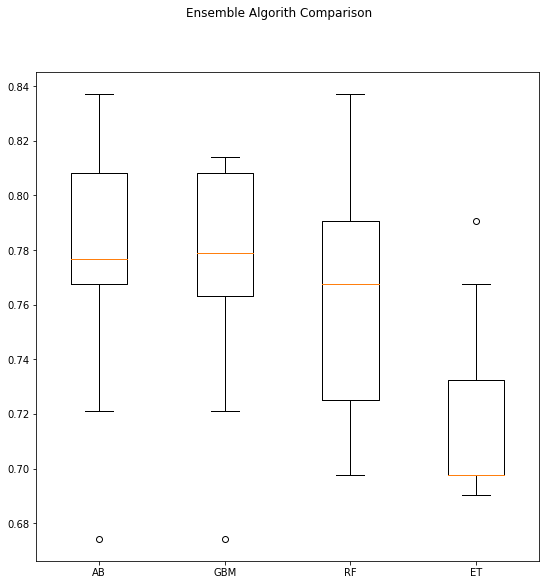

In [172]:
fig = plt.figure(figsize=(9,9))
fig.suptitle('Ensemble Algorith Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Finalizing  Model

In [180]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
#model = SVC(C=0.1, kernel='linear')
model = LogisticRegression(C=1, penalty='l1')
model.fit(rescaledX, Y_train)

# estimate accuarcy on validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

0.8108108108108109
[[ 28  33]
 [  2 122]]
              precision    recall  f1-score   support

           N       0.93      0.46      0.62        61
           Y       0.79      0.98      0.87       124

   micro avg       0.81      0.81      0.81       185
   macro avg       0.86      0.72      0.74       185
weighted avg       0.84      0.81      0.79       185



## Predicting on test dataset

In [261]:
# load test dataset
df_test = pd.read_csv('test_lAUu6dG.csv')
df_test.head()
df_test.shape

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


(367, 12)

In [262]:
# sum of missing values 
df_test.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [263]:
# imputing both categorical and numerical values
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_test = pd.DataFrame(imp.fit_transform(df_test),columns=df_test.columns,index=df_test.index)

In [264]:
# sum of missing values 
df_test.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [265]:
# change data types
df_test = df_test.astype({'ApplicantIncome': np.int64, 'CoapplicantIncome':float,
                'LoanAmount':float,'Loan_Amount_Term':float, 'Credit_History':float})

In [266]:
# get unique values
df_test.Gender.unique()
df_test.Married.unique()
df_test.Dependents.unique()
df_test.Education.unique()
df_test.Self_Employed.unique()
df_test.Property_Area.unique()

array(['Male', 'Female'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['0', '1', '2', '3+'], dtype=object)

array(['Graduate', 'Not Graduate'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['Urban', 'Semiurban', 'Rural'], dtype=object)

In [267]:
# apply encoding_scheme to Gender 
encoding_schema(df_test, 'Gender', 'GenderLabel')

# apply encoding_scheme to Married 
encoding_schema(df_test, 'Married', 'MarriedLabel')

# apply encoding_scheme to Dependents
encoding_schema(df_test, 'Dependents', 'DependentsLabel')

# apply encoding_scheme to Education
encoding_schema(df_test, 'Education', 'EducationLabel')

# apply encoding_scheme to Self_Employed
encoding_schema(df_test, 'Self_Employed', 'Self_EmployedLabel')

# apply encoding_scheme to Property_Area
encoding_schema(df_test, 'Property_Area', 'Property_AreaLabel')

"Labels for Gender are {0: 'Female', 1: 'Male'}"

"Labels for Married are {0: 'No', 1: 'Yes'}"

"Labels for Dependents are {0: '0', 1: '1', 2: '2', 3: '3+'}"

"Labels for Education are {0: 'Graduate', 1: 'Not Graduate'}"

"Labels for Self_Employed are {0: 'No', 1: 'Yes'}"

"Labels for Property_Area are {0: 'Rural', 1: 'Semiurban', 2: 'Urban'}"

In [268]:
# get rid of unuseful column
columns_to_keep  = ['Loan_ID', 'GenderLabel', 'MarriedLabel', 'DependentsLabel', 'EducationLabel',
       'Self_EmployedLabel', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_AreaLabel']

df_test = df_test[columns_to_keep]
df_test.dtypes

Loan_ID                object
GenderLabel             int64
MarriedLabel            int64
DependentsLabel         int64
EducationLabel          int64
Self_EmployedLabel      int64
ApplicantIncome         int64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History        float64
Property_AreaLabel      int64
dtype: object

In [269]:
# rename back the column names
old_colnames  = ['GenderLabel', 'MarriedLabel', 'DependentsLabel', 'EducationLabel',
       'Self_EmployedLabel', 'Property_AreaLabel']

new_colnames  = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area']

col_rename_dict = {i:j for i,j in zip(old_colnames,new_colnames)}
df_test = df_test.rename(columns=col_rename_dict)

In [270]:
df_test.head()
df_test.shape

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,1,1,0,0,0,5720,0.0,110.0,360.0,1.0,2
1,LP001022,1,1,1,0,0,3076,1500.0,126.0,360.0,1.0,2
2,LP001031,1,1,2,0,0,5000,1800.0,208.0,360.0,1.0,2
3,LP001035,1,1,2,0,0,2340,2546.0,100.0,360.0,1.0,2
4,LP001051,1,0,0,1,0,3276,0.0,78.0,360.0,1.0,2


(367, 12)

In [273]:
feature_names = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area']

# set index
df_test.index = df_test['Loan_ID']

X_validation = df_test[feature_names]

rescaledValidationX = scaler.transform(X_validation)
    
# calculate the predictions for each class
X_predict = model.predict(rescaledValidationX)

# create the solution dataframe
result = pd.DataFrame(data=X_predict, index=df_test['Loan_ID'], columns=['Loan_Status'])

In [274]:
# save the solution as an csv file
result.to_csv('solution.csv', header=True)